In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Example of usage

In [2]:
# Generate synthetic data
def generate_data(n_samples=1000):
    X = np.linspace(-3, 3, n_samples)
    y = np.sin(X) + np.random.normal(0, 0.1, n_samples)
    return X, y

X, y = generate_data()
X = X.reshape(-1, 1)

In [3]:
# Define the model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(1,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.01), loss='mse')
    return model

c:\Users\segun\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


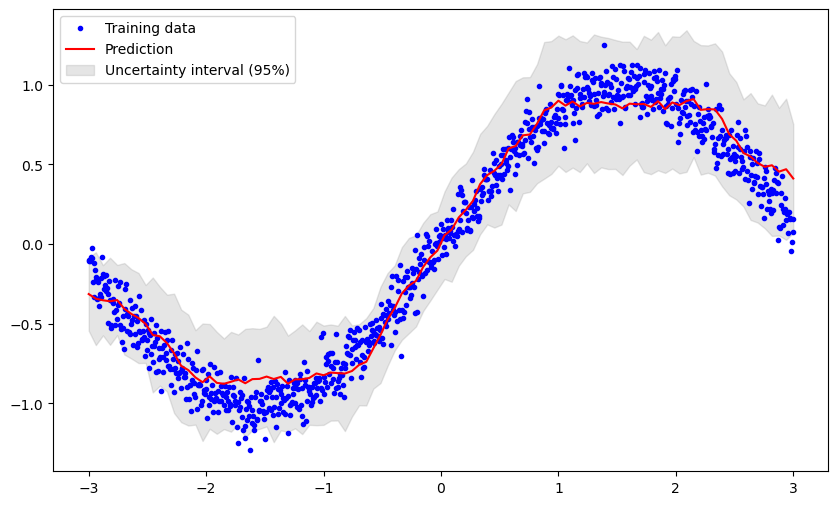

In [4]:
# Train the model
model = create_model()
model.fit(X, y, epochs=300, batch_size=32, verbose=0)

# Function to perform MC Dropout
def predict_with_uncertainty(f, x, n_iter=100):
    result = np.zeros((n_iter, x.shape[0]))
    for i in range(n_iter):
        result[i, :] = f(x, training=True).numpy().flatten()
    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction, uncertainty

# Test data
X_test = np.linspace(-3, 3, 100).reshape(-1, 1)

# Get predictions and uncertainties
y_pred, y_uncertainty = predict_with_uncertainty(model, X_test)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', label='Training data')
plt.plot(X_test, y_pred, 'r-', label='Prediction')
plt.fill_between(X_test.flatten(), 
                 y_pred - 1.96 * y_uncertainty, 
                 y_pred + 1.96 * y_uncertainty, 
                 color='gray', alpha=0.2, label='Uncertainty interval (95%)')
plt.legend()
plt.show()

## Testing with MNist dataset - Classification

In [9]:
# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape the input data
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Define the model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(784,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
model = create_model()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Function to perform MC Dropout
def predict_with_uncertainty(f, x, n_iter=100):
    result = np.zeros((n_iter, x.shape[0], 10))
    for i in range(n_iter):
        result[i, :, :] = f(x, training=True).numpy()
    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction, uncertainty

# Get predictions and uncertainties
y_pred, y_uncertainty = predict_with_uncertainty(model, X_test)

# Calculate the accuracy
accuracy = np.mean(np.equal(y_pred.argmax(axis=-1), y_test.argmax(axis=-1)))
print(f'Accuracy: {accuracy:.2f}')

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6697 - loss: 1.0255 - val_accuracy: 0.9079 - val_loss: 0.3583
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7699 - loss: 0.7792 - val_accuracy: 0.9024 - val_loss: 0.3519
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7748 - loss: 0.7541 - val_accuracy: 0.9015 - val_loss: 0.3769
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7741 - loss: 0.7569 - val_accuracy: 0.9093 - val_loss: 0.3617
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7806 - loss: 0.7453 - val_accuracy: 0.8989 - val_loss: 0.4430
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7738 - loss: 0.7540 - val_accuracy: 0.9022 - val_loss: 0.4169
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7750 - loss: 0.7551 - val_accuracy: 0.9035 - val_loss: 0.3505
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7730 - loss: 0.7665 - 

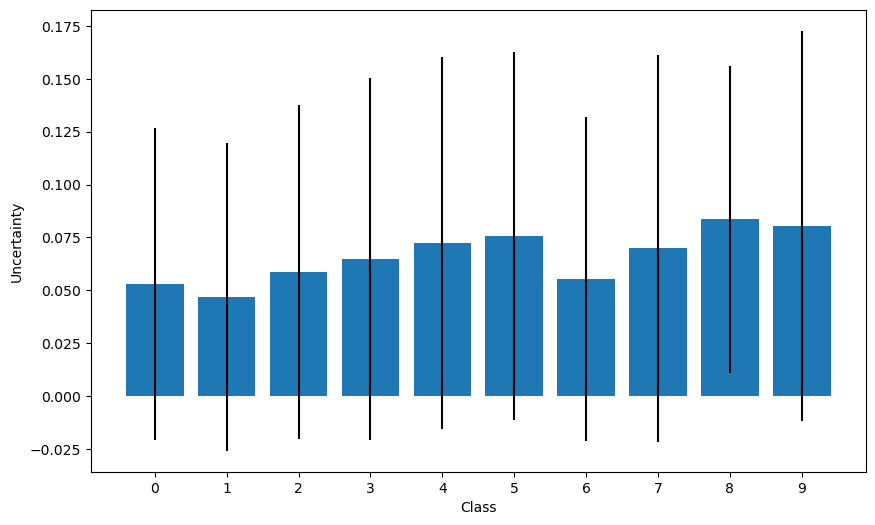

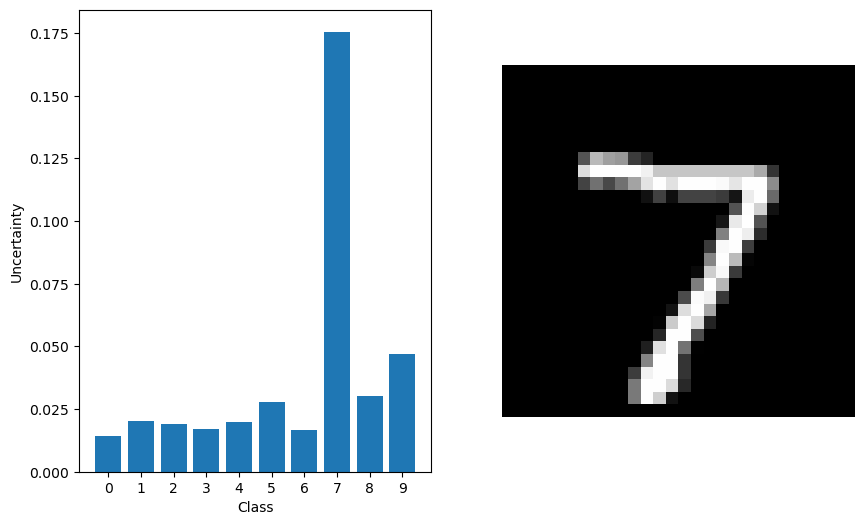

In [17]:
# Plotting the the bar chart of the uncertainty
plt.figure(figsize=(10, 6))
plt.bar(range(10), y_uncertainty.mean(axis=0), yerr=y_uncertainty.std(axis=0))
plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Uncertainty')
plt.show()

# Plotting the uncertainty for 1 sample with it image by the side
sample_idx = 0
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(10), y_uncertainty[sample_idx])
plt.xticks(range(10))
plt.xlabel('Class')
plt.ylabel('Uncertainty')
plt.subplot(1, 2, 2)
plt.imshow(X_test[sample_idx].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.7697 - loss: 0.7064 - val_accuracy: 0.9780 - val_loss: 0.0714
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9610 - loss: 0.1327 - val_accuracy: 0.9854 - val_loss: 0.0451
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9726 - loss: 0.0925 - val_accuracy: 0.9871 - val_loss: 0.0395
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9749 - loss: 0.0786 - val_accuracy: 0.9892 - val_loss: 0.0337
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.9797 - loss: 0.0708 - val_accuracy: 0.9908 - val_loss: 0.0280
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9809 - loss: 0.0610 - val_accuracy: 0.9908 - val_loss: 0.0260
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9837 - loss: 0.0533 - val_accuracy: 0.9914 - val_loss: 0.0264
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9848 - loss: 0.0516 - 

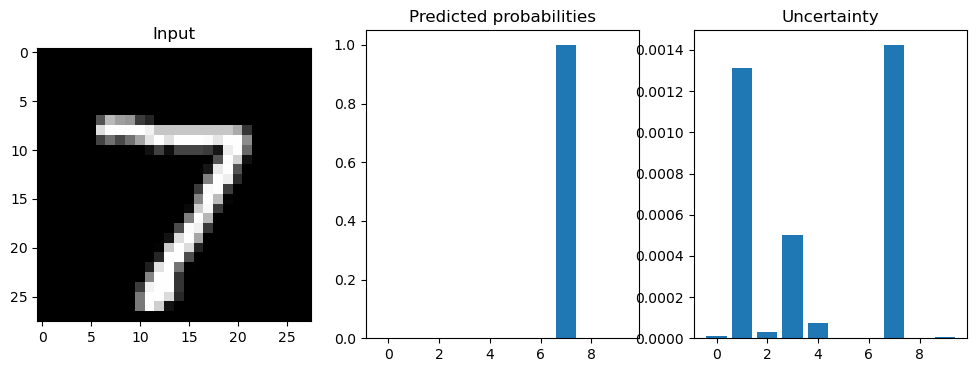

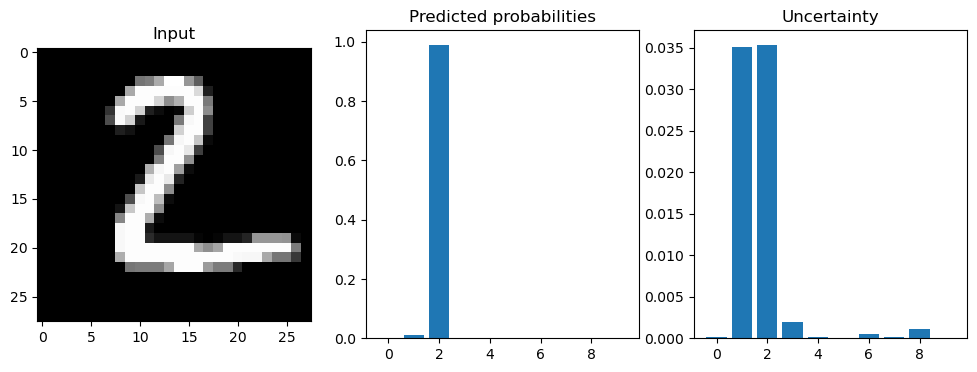

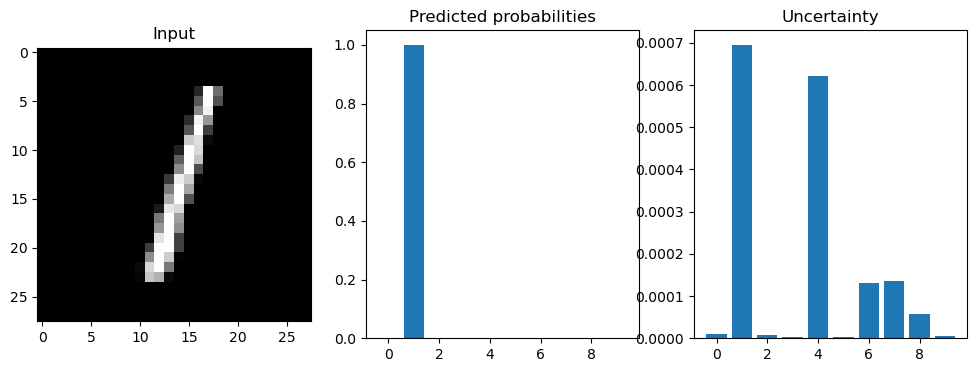

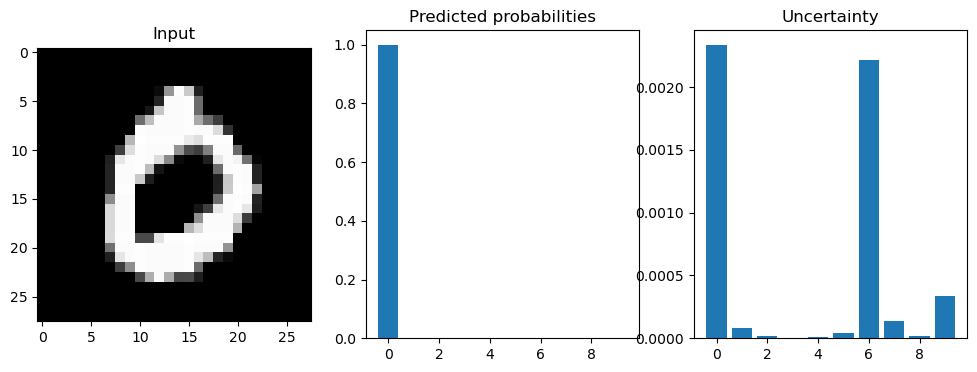

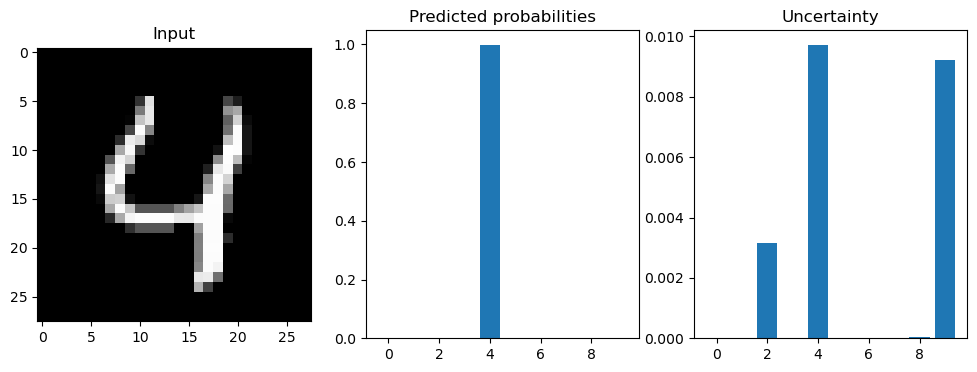

Accuracy: 99.30%
Mean Uncertainty: 0.0098


In [21]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the neural network with dropout layers
def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train the model
model = create_model()
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Function to perform MC Dropout
@tf.function
def mc_dropout_predict(model, x, n_iter=100):
    predictions = []
    for _ in range(n_iter):
        predictions.append(model(x, training=True))
    predictions = tf.stack(predictions)
    prediction_mean = tf.reduce_mean(predictions, axis=0)
    prediction_std = tf.math.reduce_std(predictions, axis=0)
    return prediction_mean, prediction_std

# Evaluate uncertainty on test data
n_samples = 1000
x_test_sample = x_test[:n_samples]
y_test_sample = y_test[:n_samples]

y_pred, y_uncertainty = mc_dropout_predict(model, x_test_sample, n_iter=100)

# Convert predictions and uncertainties to numpy arrays for further processing
y_pred = y_pred.numpy()
y_uncertainty = y_uncertainty.numpy()

# Visualize uncertainty for a few samples
def plot_uncertainty(x, y_true, y_pred, y_uncertainty, idx):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(x[idx].reshape(28, 28), cmap='gray')
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.bar(range(10), y_pred[idx])
    plt.title("Predicted probabilities")
    plt.subplot(1, 3, 3)
    plt.bar(range(10), y_uncertainty[idx])
    plt.title("Uncertainty")
    plt.show()

for i in range(5):
    plot_uncertainty(x_test_sample, y_test_sample, y_pred, y_uncertainty, i)

# Evaluate accuracy and uncertainty
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_sample, axis=1)
accuracy = np.mean(y_pred_classes == y_true_classes)
mean_uncertainty = np.mean(y_uncertainty)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Mean Uncertainty: {mean_uncertainty:.4f}")

## Usage on California Housing dataset - Regression

In [60]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use only the MedInc feature
X_train = X_train[:, [0]]
X_test = X_test[:, [0]]

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [61]:
# Define the model
def create_model(dropout_rate=0.5):
    model = Sequential([InputLayer(input_shape=(X_train.shape[1],)),
             Dropout(0.4),          
			 Dense(1000, activation="selu", kernel_initializer="lecun_normal"),
             Dropout(0.4),
             Dense(2000, activation="selu", kernel_initializer="lecun_normal"),
             Dropout(0.4),
             Dense(2000, activation="selu", kernel_initializer="lecun_normal"),
			 Dropout(0.4),
             Dense(1000, activation="selu", kernel_initializer="lecun_normal"),
			 Dropout(0.4),
             Dense(1, activation=None)
			 ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = create_model()
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

c:\Users\segun\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 55s 128ms/step - loss: 84.9154 - val_loss: 2.2528
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - loss: 2.5347 - val_loss: 0.8230
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 53s 129ms/step - loss: 1.9801 - val_loss: 0.9148
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 52s 125ms/step - loss: 1.7147 - val_loss: 1.0983
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 52s 125ms/step - loss: 1.4539 - val_loss: 0.8773
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 54s 130ms/step - loss: 1.2739 - val_loss: 0.8445
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 52s 127ms/step - loss: 1.1807 - val_loss: 0.7524
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 54s 129ms/step - loss: 1.1417 - val_loss: 1.0414
Epoch 9/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 57s 139ms/step - loss: 1.1295 - val_loss: 1.0006
Epoch 10/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 59s 142ms/step - loss: 1.1052 - val_loss: 0.9349
Epoch 11/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - loss: 1.0756 - val_loss: 0.8826
Epoch 12/20
413/41

In [62]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

fig = go.Figure()

fig.add_trace(go.Scatter(x=X_test[:, 0], y=y_test, mode='markers', name='True values'))
fig.add_trace(go.Scatter(x=X_test[:, 0], y=model.predict(X_test).flatten(), mode='markers', name='Predictions'))

fig.show()

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [ ]:
def mc_dropout_predict(model, X_test, n_iter=100):
    f = tf.function(lambda x: model(x, training=True))
    preds = np.array([f(X_test).numpy() for _ in range(n_iter)])
    predictive_mean = np.mean(preds, axis=0)
    predictive_variance = np.var(preds, axis=0)
    return preds, predictive_mean, predictive_variance

# Perform Monte Carlo Dropout
preds, predictive_mean, predictive_variance = mc_dropout_predict(model, X_test, n_iter=100)

In [75]:
preds.shape, predictive_mean.shape, predictive_variance.shape

((100, 4128, 1), (4128, 1), (4128, 1))

In [70]:
X_test.shape

(4128, 1)

In [85]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test[:, 0], y=y_test, mode='markers', name='True values'))
for i in range(10):
    fig.add_trace(go.Scatter(x=X_test[:, 0], y=preds[i].flatten(), mode='markers', opacity=0.1, showlegend=False, marker=dict(color='red')))
fig.show()

In [86]:
fig = go.Figure()
#plot mean and mean varianca
fig.add_trace(go.Scatter(x=X_test[:, 0], y=predictive_mean.flatten(), mode='markers', name='Predictive mean'))
fig.add_trace(go.Scatter(x=X_test[:, 0], y=predictive_variance.flatten(), mode='markers', name='Predictive variance'))
fig.show()